In [122]:
from bs4 import BeautifulSoup as soup
import pandas as pd
import requests
import datetime
# from selenium import webdriver
!pip install kora -q
from kora.selenium import wd


In [124]:
base_url="https://www.99acres.com/property-in-hinjewadi-pune-ffid-page-"

def dataset(url,n):
  all_items=[]#store all rows as a list of dict
  
  for i in range(1,n):

    wd.get(url+str(i))
    tables=wd.find_elements_by_class_name("srpTuple__tupleTable")
   
    for table in tables:
      try:
        Specification=table.find_element_by_xpath('.//*[@id="srp_tuple_property_title"]/h2').text
      except:
        Specification=None
      try:
        Project=table.find_element_by_xpath('.//*[@id="srp_tuple_society_heading"]/a').text
      except:
        Project=None
      try:
        Area=table.find_element_by_xpath('.//*[@id="srp_tuple_primary_area"]').text
      except:
        Area=None
      try:
        sqft=table.find_element_by_xpath('.//*[@id="srp_tuple_primary_area_unit"]').text
      except:
        sqft=None
      try:
        sqmt=table.find_element_by_xpath('.//*[@id="srp_tuple_secondary_area"]').text
      except:
        sqmt=None
      try:
        Area=Area.replace(sqft,'')
        Area=Area.replace(sqmt,'')
        Area=Area.replace('\n','')
        Area=Area.replace(',','')
      except:
        None
      try:
        Area=Area[:Area.index('-')]
        Area=float(Area)
      except:
        None
      try:
        #price per sqft
        Price=table.find_element_by_xpath('.//*[@id="srp_tuple_price_per_unit_area"]').text
        Price=Price.replace('/sq.ft.','')
        Price=Price.replace(',','')
        Price=Price.replace('₹','')
        Price=float(Price)
      except:
        Price=None

      item={
          'specification':Specification,
          'project':Project,
          'area':Area,
          'price':Price
      }
      all_items.append(item)
      # print(Price)
      # //*[@id="srp_tuple_primary_area"]/text()
      # //*[@id="srp_tuple_primary_area"]/text()

  df=pd.DataFrame(all_items)
  return df



In [126]:
data=dataset(base_url,31)
data.isna().sum()
# print(data.shape)

specification      0
project          130
area               0
price             92
dtype: int64

In [127]:
data.shape

(780, 4)

In [128]:
data.to_csv("99acres_data.csv")

In [243]:
data.head()

,specification,project,area,price
0,Residential land / Plot in Hinjewadi,Aarohi Park,1076,2999.0
1,1 BHK Residential Apartment in Hinjewadi,SBM Aviva,455,8495.0
2,2 BHK Residential Apartment in Hinjewadi,SBM Aviva,619,9427.0
3,3 BHK Residential Apartment in Phase-3 Hinjewadi,Kasturi Eon Homes,945,9029.0
4,2 BHK Residential Apartment in Phase-3 Hinjewadi,Kasturi Eon Homes,824,8914.0


In [157]:
df=data.copy()

In [158]:
df.shape

(780, 4)

In [159]:
#drop rows having null values
df.dropna(axis=0,inplace=True)
df.shape

(568, 4)

In [134]:
#save data to csv
df.to_csv("99acres_cleaned.csv")

In [137]:
df.columns[:2]

Index(['specification', 'project'], dtype='object')

In [160]:
#lable Encode the categorical variables
from sklearn.preprocessing import LabelEncoder
for c in df.columns[:2]:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

In [161]:
df.head()

,specification,project,area,price
0,19,1,1076,2999.0
1,1,44,455,8495.0
2,7,44,619,9427.0
3,16,14,945,9029.0
4,11,14,824,8914.0


In [141]:
df['project'].unique()

array([ 1, 44, 14, 63,  8, 54, 39, 18, 15,  2, 45,  7, 36, 32, 38, 17, 31,
       53, 60, 29, 20, 43, 35, 34,  0, 40, 33, 41, 28, 23, 62,  6, 59, 13,
       30, 27, 24, 26, 25, 47, 42, 67, 55, 37, 22,  4, 68, 51, 19, 49, 66,
        5, 12, 61, 21,  9, 65, 64, 50, 57, 16, 52, 11, 46,  3, 48, 56, 10,
       58])

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


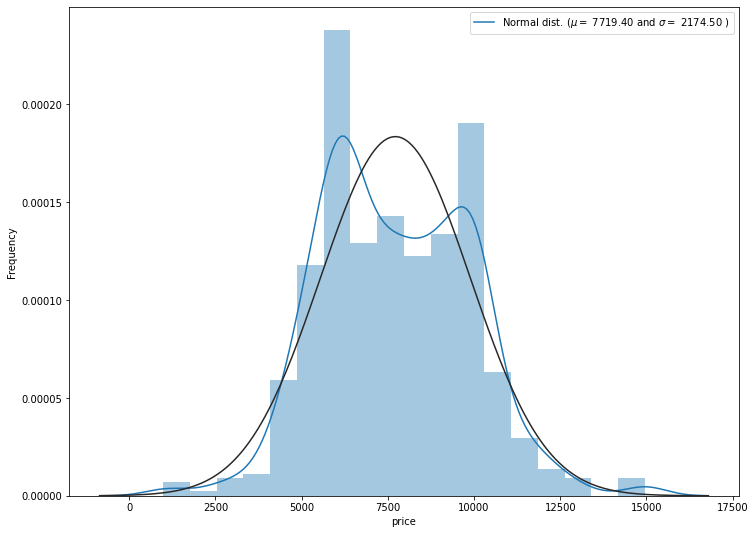

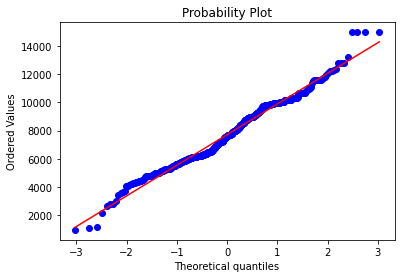

In [228]:
#chech Normality of continuous variable
plt.subplots(figsize=(12,9))
sns.distplot(df['price'], fit=stats.norm)

(mu, sigma) = stats.norm.fit(df['price'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

fig = plt.figure()
stats.probplot(df['price'], plot=plt)
plt.show()

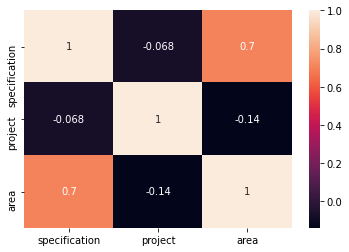

In [245]:
#applying log to continuous variables to normalize them
train_target=df['price']
train_features=df.drop(['price'],axis=1)
train_features['area']=train_features['area'].apply(int)
train_features['area']= np.log1p(train_features['area'])
train_target=np.log1p(train_target)


#Multiply area with price as price was per sqft
train_target=train_target*train_features['area']
corr=train_features.corr()
plt.subplots()
sns.heatmap(corr, annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

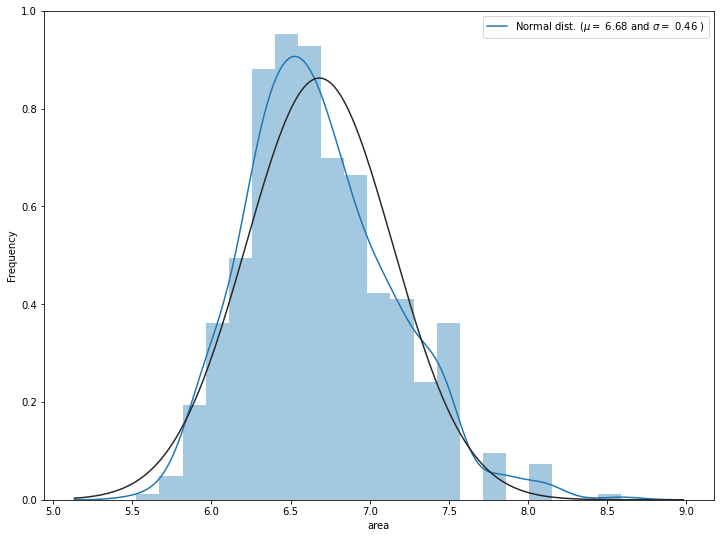

In [246]:
#chech Normality of continuous variable
plt.subplots(figsize=(12,9))
sns.distplot(train_features['area'], fit=stats.norm)

(mu, sigma) = stats.norm.fit(train_features['area'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')


In [247]:
train_features.head()

,specification,project,area
0,19,1,6.981935
1,1,44,6.122493
2,7,44,6.429719
3,16,14,6.852243
4,11,14,6.715383


In [248]:
#train_test_split the datset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size=0.2, random_state=7)


## Linear Regression

In [249]:
from sklearn import linear_model
LinR = linear_model.LinearRegression()
LinR.fit(X_train, y_train)
print("Accuracy Score: ", LinR.score(X_test, y_test)*100)

Accuracy Score:  77.88718264781807


## Random Forest

In [250]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators=1000)
RF.fit(X_train, y_train)
print("Accuracy Score: ", RF.score(X_test, y_test)*100)

Accuracy Score:  87.38423537038513


## Gradient Boosting

In [251]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=100, max_depth=4)
GBR.fit(X_train, y_train)
print("Accuracy Score ", GBR.score(X_test, y_test)*100)

Accuracy Score  91.35231630411997


## XGBoost

In [252]:
from xgboost import XGBRegressor
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
print("Accuracy Score ", XGBR.score(X_test, y_test)*100)

[19:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy Score  93.51973833661877
